<a href="https://colab.research.google.com/github/HermonaDev/Flora-Guard/blob/main/FloraGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

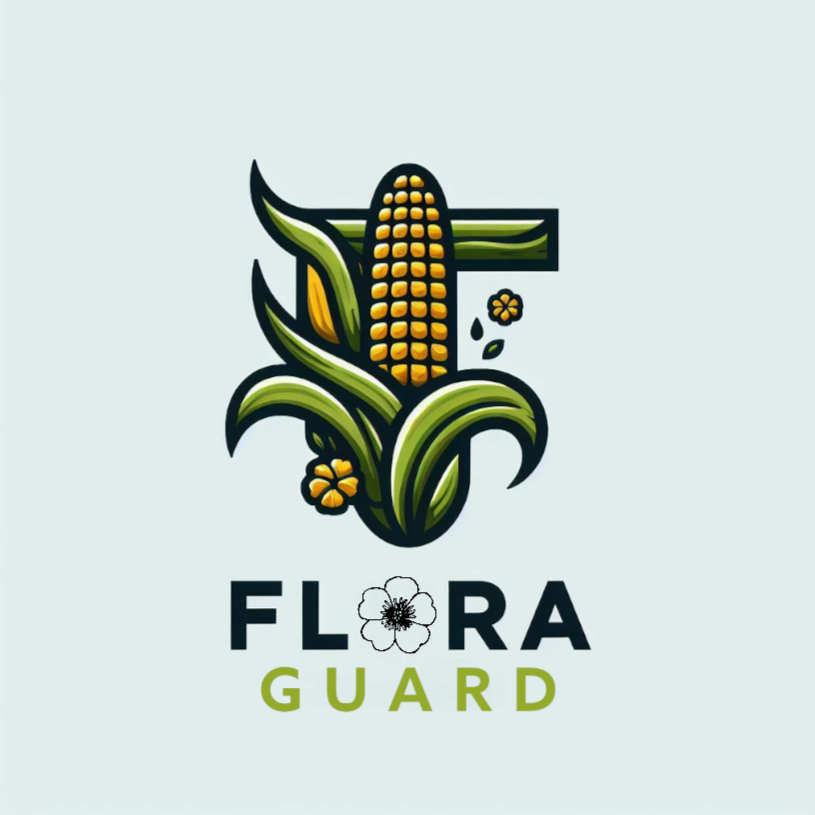

## Background
Getting affected by a disease is very common in plants due to various factors such as fertilizers, cultural practices followed, environmental conditions, etc. These diseases hurt agricultural yield and eventually the economy based on it.
Any technique or method to overcome this problem and getting a warning before the plants are infected would aid farmers to efficiently cultivate crops or plants, both qualitatively and quantitatively. Thus, disease detection in plants plays a very important role in agriculture.

# Introduction

This project tries to build a model using the power of **Keras**, a high-level neural networks API, capable of running on top of TensorFlow. It leverages the **MobileNet architecture**, known for its efficiency and performance, making the model lightweight yet incredibly powerful.

The model is deployed using **TensorFlow**, the world's most comprehensive and flexible platform for machine learning. This allows the model to learn from vast amounts of data and make accurate predictions, all while being scalable and robust.

With our Plant Disease Detection Model, diagnosing plant diseases is as simple as taking a photo. The model analyzes the image, identifies potential diseases, and provides results in seconds. This rapid and precise detection can save crops, increase yield, and ultimately feed more people.

We use a publicly available and quite famous, the PlantVillage Dataset


## Libraries
We import all the necessary libraries required to process the data and build the classification model.

In [10]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D

################

import cv2
import PIL
from tensorflow.python import keras
import warnings
import argparse
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


## Mounting google drive

The first time running the notebook will require you to allow access to your drive from colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/FloraGuard'

/content/drive/My Drive/FloraGuard


In [ ]:
!mkdir config datasets checkpoints models

mkdir: cannot create directory ‘config’: File exists
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘models’: File exists


In [ ]:
cd '/content/drive/My Drive/FloraGuard/config'

/content/drive/My Drive/FloraGuard/config


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/FloraGuard/config"

Download Dataset

In [ ]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip Data

In [11]:
!unzip \*.zip  && rm *.zip

Archive:  plantvillage-dataset.zip
replace plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [12]:
!pwd

/content/drive/MyDrive/FloraGuard/datasets


Split the Data

In [13]:
pip install split-folders[full]

In [14]:
import splitfolders

In [15]:
input_file="plantvillage dataset/color"
output_file="plantvillage dataset splitted"

In [ ]:
splitfolders.ratio(input_file, output=output_file, seed=42, ratio=(.7,.2,.1), group_prefix=None)

Copying files: 7585 files [36:42,  3.60 files/s]

In [ ]:
!pwd

In [ ]:
base_path = './plantvillage dataset splitted'

train_data_dir = base_path + "/train"
val_data_dir = base_path + "/val"

!dir

In [ ]:
len(os.listdir(os.path.join(base_path, 'train')))

In [ ]:
img_size, batch_size, shuffle_size = 224, 32, 1000
img_shape = (img_size, img_size, 3)

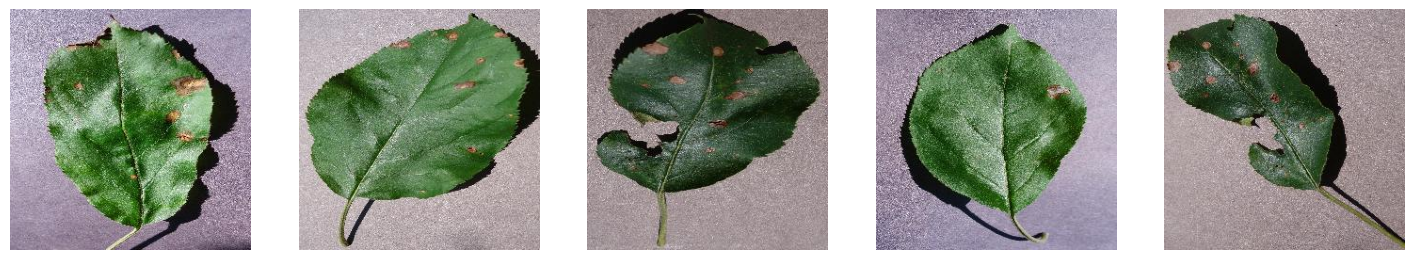

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
images = os.listdir(os.path.join(base_path, 'train/Apple___Black_rot'))
for _ in range(5):
  ax = axes[_]
  image_path = base_path+'/train/Apple___Black_rot/'+images[_]
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.axis('off')
plt.show()

## Data Augmentation & Preprocessing

In [ ]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_datagen = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_datagen = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


## Saving the dataset labels
The generators has an attribute named `class_indices` that contains the data labels that have been supplied by keras.

We save this into a variable since we will require it later.

In [ ]:
labels = train_datagen.class_indices

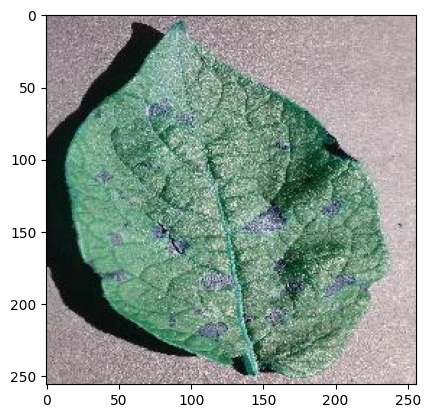

In [ ]:
img = train_datagen.filepaths[np.random.random_integers(low=0, high=train_datagen.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [ ]:
import json
with open('/content/drive/My Drive/FloraGuard/checkpoints/labels.json','w') as f:
  json.dump(labels, f)

## Building the model with MobileNetV2
Keras comes packed with some models and for our case we will be using the predesigned MobileNetV2. We will be applying **Transfer Learning**

In [ ]:
#The model starts with a standard convolution (Conv2D) layer followed by batch normalization (BatchNormalization) and ReLU activation (ReLU). This is followed by a depthwise convolution (DepthwiseConv2D), which is a space-saving operation that performs a convolution on each input channel separately. The depthwise convolution is also followed by batch normalization and ReLU activation.
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)

mobile_net.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Fine Tuning the model


In [ ]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(38, activation='softmax')(x)


model = Model(mobile_net.input, x)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,114,022 (15.69 MB)

 Trainable params: 2,908,518 (11.10 MB)

 Non-trainable params: 1,205,504 (4.60 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
checkpoint = ModelCheckpoint("pdd_mobilenet2_v1.h5.keras", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
step_size = train_datagen.n//train_datagen.batch_size
print(step_size)

1187


In [ ]:

model_history = model.fit(
    train_datagen,
    epochs=5,
    steps_per_epoch=step_size,
    validation_data=val_datagen,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/5
 639/1187 ━━━━━━━━━━━━━━━━━━━━ 22:41 2s/step - acc: 0.7223 - loss: 1.0804

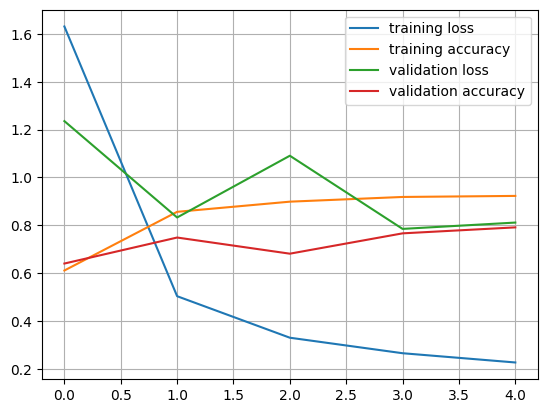

In [ ]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [ ]:
# Evaluate the model on the Validation dataset
results = model.evaluate(val_datagen)

340/340 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - acc: 0.7582 - loss: 0.9408


In [ ]:
train_results = model.evaluate(train_datagen)

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2412s 2s/step - acc: 0.7625 - loss: 0.9213


In [ ]:
print("Training Loss :-", train_results[0])
print("="*30)
print("Training Accuracy :-", train_results[1])

Training Loss :- 0.9191041588783264
Training Accuracy :- 0.7650340795516968


In [ ]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

Validation Loss :- 0.9380754232406616
Validation Accuracy :- 0.7611761689186096


It's essential to compare the validation loss with the training loss. If the training loss is significantly lower than the validation loss, it might suggest overfitting. Ideally, the training and validation losses should be close, indicating good generalization.

In [ ]:
cd '/content/drive/My Drive/FloraGuard/models'

/content/drive/My Drive/FloraGuard/models


**Saving the Model**

In [ ]:
model.save('pdd_mobilenet2_v1.h5')

In [ ]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


# Testing the Model

In [ ]:
import random
from PIL import Image
import glob

base_path = './plantvillage dataset splitted'
idx = np.random.randint(30)
test_images_dir = os.path.join(base_path, 'test')

# Get a list of subdirectories within the test_images_dir
subdirectories = [d for d in os.listdir(test_images_dir) if os.path.isdir(os.path.join(test_images_dir, d))]

# Choose a random subdirectory
random_subdirectory = random.choice(subdirectories)

# Get a list of image files within the chosen subdirectory
image_files = glob.glob(os.path.join(test_images_dir, random_subdirectory, '*.jpg'))

if image_files:
    # Choose a random image file from the list
    random_image = random.choice(image_files)

    # Open the random image file
    test1 = Image.open(random_image)
else:
    print("No image files found in the directory:", os.path.join(test_images_dir, random_subdirectory))


Text(0.5, 1.0, 'Squash___Powdery_mildew')

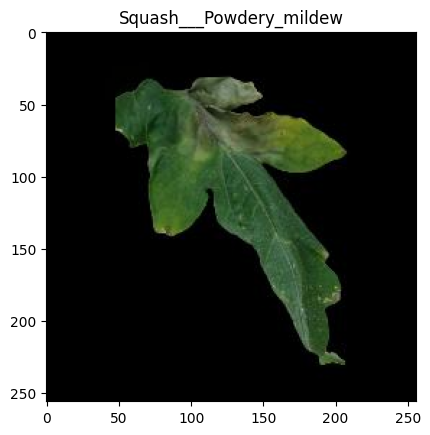

In [ ]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

Predicting the Disease

In [ ]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = model.predict(test1_scaled)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[1.6649731e-02 1.7197312e-04 3.7339749e-05 3.3044228e-03 6.1839478e-06
  6.5725195e-05 1.2421112e-04 9.9629306e-06 9.4505376e-05 3.3218988e-05
  2.2008424e-03 2.0745114e-04 5.6885806e-06 1.6412911e-05 1.3822891e-01
  3.7371914e-04 1.1674944e-06 1.3814910e-04 3.8994272e-06 2.4725037e-04
  2.1290391e-06 4.5427946e-06 2.5348987e-05 6.9237154e-05 1.6000790e-04
  2.3088498e-01 3.1547956e-05 7.7532692e-04 1.7094314e-04 3.6873978e-05
  6.0135591e-01 5.8744899e-05 1.6316735e-04 8.5118011e-04 1.3860346e-04
  1.4204143e-04 2.4360279e-04 2.9650810e-03]]


In [ ]:
labels = train_datagen.class_indices
labels = { v:k for (k,v) in labels.items() }
labels[np.argmax(predictions)]

'Tomato___Late_blight'

# Deploying with Tensorflowjs

This will be achieved by converting the Python model to a Javascript-compatible format, using ‘ tensorflowjs-converter’ — An efficient Python module that converts saved Keras models to formats compatible with Javascript.

In [ ]:
# Converting the Keras Model to Tensorflow.js compatible model
!pip install tensorflowjs

In [ ]:
cd '/content/drive/MyDrive/FloraGuard'

/content/drive/MyDrive/FloraGuard


In [ ]:
!mkdir tensorflowjs-model

mkdir: cannot create directory ‘tensorflowjs-model’: File exists


In [ ]:
!pwd

/content/drive/MyDrive/FloraGuard


In [ ]:
ls

checkpoints/  config/  datasets/  models/  tensorflowjs-model/  tensorflowjs-model.zip


In [ ]:
!tensorflowjs_converter --input_format keras models/pdd_mobilenet2_v1.h5 tensorflowjs-model/

2024-03-23 20:27:38.063579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 962, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 948, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 618, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/loca

In [ ]:
# Download the converted model
!zip -r tensorflowjs-model.zip tensorflowjs-model

updating: tensorflowjs-model/ (stored 0%)
updating: tensorflowjs-model/group1-shard1of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard2of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard3of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard4of4.bin (deflated 8%)
updating: tensorflowjs-model/model.json (deflated 96%)


In [ ]:
!cp '/content/drive/MyDrive/FloraGuard/checkpoints/labels.json' 'C:\Users\Hermona\Downloads'

In [ ]:
def preprocess_image(file):
  path = '/content/drive/MyDrive/FloraGuard/datasets/plantvillage dataset splitted/test/'
  img = image.load_img(path + file, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)


In [ ]:
def get_prediction(image, level='all'):
  preprocessed_image = preprocess_image(image)
  predictions = model.predict(preprocessed_image)

  ind = np.argpartition(predictions[0], -5)[-5:]
  result = np.argmax(predictions[0])
  top5= predictions[0][ind]

  if level == 'single':
     for k,v in labels.items():
       if v == result: return k;
  else:
    for k,v in labels.items():
      if v in np.sort(ind):
        idx = np.where(ind == v)[0]
        print(f'{top5[idx]} ~> {k}')





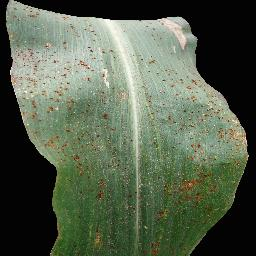

In [ ]:
from IPython.display import Image
Image(filename = '/content/drive/MyDrive/FloraGuard/datasets/plantvillage dataset splitted/test/Corn_(maize)___Common_rust_/RS_Rust 1576.JPG', width=300, height=200)

In [ ]:
ans = get_prediction('Corn_(maize)___Common_rust_/RS_Rust 1576.JPG')
ans

NameError: name 'preprocess_image' is not defined